# Detect Open Doors Using Object Detection

This notebook runs an object detection model developed in LandingLens to detect if a door is open or closed. For ease of use, the notebook uses a test image, but you can customize the code to use the feed from an RTSP camera.

In [1]:
#@title Set the following variables as needed for your setup
api_key         = "dvkyqd942h90wn1t3fsbjshsud3xdgs"  #@param {type:"string"}
api_secret      = "gj95e8antnkhcduuwrgok3efrtwpzqojykc05l8yiuxnaecxdqxvawrir0d3yw"  #@param {type:"string"}
# In order to find the URL for your camera, this is a good start https://www.ispyconnect.com/cameras
# camera_url      =  "rtsp://172.25.101.151/ch0_0.h264" #@param {type:"string"}
camera_url      =  './sample_images/door_%02d.jpg' # Use sample images
# camera_url      =  0 # Connect to local webcam
model_endpoint  =  "c0791de7-66e3-4970-9a87-064e5e3b07ee" #@param {type:"string"}

In [8]:
!pip install landingai

Obtaining file:///Users/matias/repos/landingai-python
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for landingai (pyproject.toml) ... done
  Created wheel for landingai: filename=landingai-0.0.13-py3-none-any.whl size=3884 sha256=6034333c08a260666383ddbb10e627fe2c16dd48a542e1597501e7f82a6aa88b
  Stored in directory: /private/var/folders/kg/8147cpvj6b39c3v1gkgm16mh0000gn/T/pip-ephem-wheel-cache-8vqfse49/wheels/bf/9f/56/ef0cce62fb3e0ed8dd3773646c43b2fb505e3051b93f3b4114
Successfully built landingai
  Attempting uninstall: landingai
    Found existing installation: landingai 0.0.13
    Uninstalling landingai-0.0.13:
      Successfully uninstalled landingai-0.0.13

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


## Acquire an Image

In below cell, we are simulating a camera stream by setting the `camera_url` to an image file. In reality, you can replace the `camera_url` with a real one. 

Tip: Setting `camera_url` to 0 will connect to your web camera by default for most laptops.

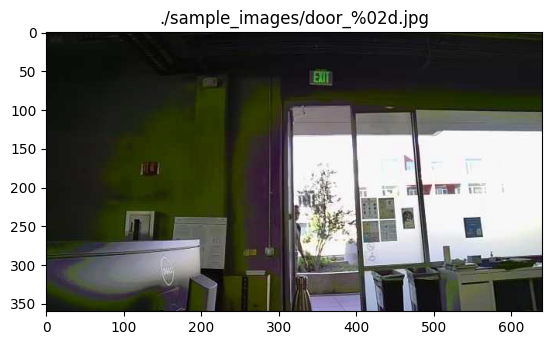

In [3]:
import cv2
from matplotlib import pyplot as plt

# Open connection to camera
vcap = cv2.VideoCapture(camera_url)

# Capture frame-by-frame
ret, frame = vcap.read()

# Convert color space to RGB
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Show the captured image
plt.imshow(frame)
plt.title(camera_url)
plt.show()

## Run Inference Using the Object Detection Model

Previously, we have trained and deployed an Object Detection model on LandingLens that detects a door and classify the open or close state.

In below cell, we call the `Predictor` to get the prediction result for the camera frame we captured above.

The prediction result is a list of `ObjectDetectionPrediction` instances. Each `ObjectDetectionPrediction` instance reprents a predicted bounding box with the predicted confidence score and predicted class name.

In [4]:
from landingai.predict import Predictor
from landingai.visualize import overlay_predictions
        
predictor = Predictor(model_endpoint, api_key, api_secret)

# Run prediction and show raw results
results = predictor.predict(frame)
display(results)

[ObjectDetectionPrediction(score=0.8386361598968506, label_name='Open', label_index=1, id='7406f6d7-20e8-43d4-83db-245c92820825', bboxes=(301, 87, 418, 359))]

## Visualize the Results

To visualize the predicted bounding-box, we can call the `overlay_predictions`.

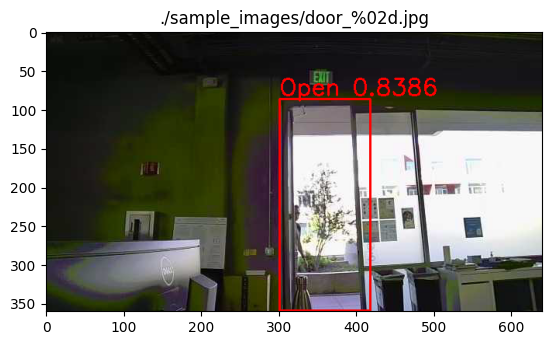

In [5]:
# Draw raw results on the original image
frame = overlay_predictions(results, image=frame)
plt.imshow(frame)
plt.title(camera_url)
plt.show()


## Process the Results to Determine if the Door Is Open or Closed

Now we have the predictions. We defined below rules to decide if the door is open:

1. If there is no predictions, the door is closed.
2. If there are predictions, find the prediction with the highest confidence score, use its predicted class as the result, i.e. Open or Close.

The code is as follow.

In [6]:
from IPython.display import display, Markdown
# For better accuracy we look at the top detection and only claim that hte door is closed if we identify it as such. If the door is partially open or fully open it will be reported as open
if len(results) > 0:
    top_detection = max(results, key=lambda x: x.score)
    if top_detection.label_name == "Closed":
        display(Markdown('# The door is closed'))
    else:
        display(Markdown('# The door is not closed'))
else:
    display(Markdown('# The door is not closed'))


# The door is not closed